In [1]:
import os
import tensorflow.keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, Reshape
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import numpy as np
import pandas as pd
import glob
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import cv2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/PIBD/Carbonate_img.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/PIBD/dataset')

In [3]:
len(os.listdir('/content/drive/MyDrive/PIBD/dataset/imagette_grayscale'))

980

In [4]:
#load images into array
img_filename = glob.iglob("/content/drive/MyDrive/PIBD/dataset/imagette_grayscale/*.png")
img = np.array([np.array(cv2.imread(fname,cv2.IMREAD_GRAYSCALE)) for fname in img_filename])
img = cv2.normalize(img,  None, 0, 255, cv2.NORM_MINMAX)

mask_filename = glob.iglob("/content/drive/MyDrive/PIBD/dataset/imagette_mask/*.png")
mask = np.array([np.array(cv2.imread(fname,cv2.IMREAD_UNCHANGED)) for fname in mask_filename])
mask = cv2.normalize(mask,  None, 0, 1, cv2.NORM_MINMAX)

In [ ]:
print(np.min(img), np.max(img), img.shape, type(img))
print(np.min(mask), np.max(mask), mask.shape, type(mask))

0 255 (980, 256, 256) <class 'numpy.ndarray'>
0 1 (980, 256, 256) <class 'numpy.ndarray'>


Text(0.5, 1.0, 'Image segmentée')

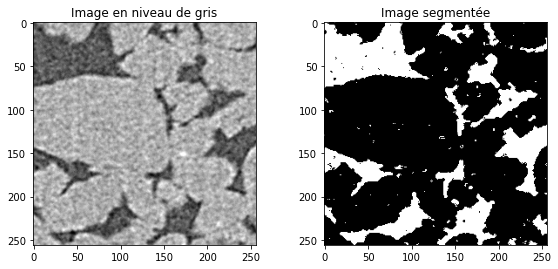

In [ ]:
#plot image and its mask
plt.figure(figsize=(20,9))
plt.subplot(2,4,2)
plt.imshow(img[200], cmap='gray')
plt.title('Image en niveau de gris')
plt.subplot(2,4,3)
plt.imshow(mask[200], cmap='gray')
plt.title('Image segmentée')

In [ ]:
print(img.shape)
print(mask.shape)

(980, 256, 256)
(980, 256, 256)


In [ ]:
#split data
from sklearn.model_selection import train_test_split
train_ratio = 0.70
test_ratio = 0.20
validation_ratio = 0.10

x_train, x_test, y_train, y_test = train_test_split(img, mask, test_size=1 - train_ratio)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio))

In [ ]:
print(len(x_train))
print(len(x_test))
len(x_val)

685
197


98

Le modèle pré-entrainé VGG16 en tant qu'encodeur

In [5]:
from keras.applications import vgg16
input_shape = (256, 256, 3)
VGG16 = vgg16.VGG16(include_top=False, weights = "imagenet", input_shape=input_shape)
print('Model loaded.')

58892288/58889256 [==============================] - 1s 0us/step
Model loaded.


In [6]:
for i, layer in enumerate(VGG16.layers):
   print(i, layer.name)

0 input_1
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool


In [7]:
output_ = VGG16.output
output_

<KerasTensor: shape=(None, 8, 8, 512) dtype=float32 (created by layer 'block5_pool')>

In [8]:
    for layer in VGG16.layers:
        layer.trainable = False

In [9]:

vgg_model = Model(VGG16.input, output_)
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.In...,input_1,False
1,<tensorflow.python.keras.layers.convolutional....,block1_conv1,False
2,<tensorflow.python.keras.layers.convolutional....,block1_conv2,False
3,<tensorflow.python.keras.layers.pooling.MaxPoo...,block1_pool,False
4,<tensorflow.python.keras.layers.convolutional....,block2_conv1,False
5,<tensorflow.python.keras.layers.convolutional....,block2_conv2,False
6,<tensorflow.python.keras.layers.pooling.MaxPoo...,block2_pool,False
7,<tensorflow.python.keras.layers.convolutional....,block3_conv1,False
8,<tensorflow.python.keras.layers.convolutional....,block3_conv2,False
9,<tensorflow.python.keras.layers.convolutional....,block3_conv3,False


Le modèle segnet-Vgg16

In [ ]:
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, Reshape
def ModelEnhancer():

# changer la couche d'entrée pour accepter l'image en niveaux de gris
    img_size_target = 256
    img_input = Input(shape=(img_size_target, img_size_target, 1))
    img_conc = tf.keras.layers.Concatenate()([img_input, img_input, img_input])  
  
    input_shape = (256, 256,3)
    VGG16 = vgg16.VGG16(input_tensor=img_conc, include_top=False, weights="imagenet", input_shape=input_shape)
    last_layer = VGG16.output

#gelé la base convolutive
    for layer in VGG16.layers:
        layer.trainable = False

     # decoder
       
    x = UpSampling2D()(last_layer)
    x= Dropout(0.5)(x)
    conv_14 = Conv2D(512, (3, 3), padding='same')(x)
    conv_14 = BatchNormalization()(conv_14)
    conv_14 = Activation('relu')(conv_14)
    conv_15 = Conv2D(512, (3, 3), padding='same')(conv_14)
    conv_15 = BatchNormalization()(conv_15)
    conv_15 = Activation('relu')(conv_15)
    conv_16 = Conv2D(512, (3, 3), padding='same')(conv_15)
    conv_16 = BatchNormalization()(conv_16)
    conv_16 = Activation('relu')(conv_16)
    
    x = UpSampling2D()(conv_16)
    x= Dropout(0.5)(x)
    conv_17 = Conv2D(512, (3, 3), padding='same')(x)
    conv_17 = BatchNormalization()(conv_17)
    conv_17 = Activation('relu')(conv_17)
    conv_18 = Conv2D(512, (3, 3), padding='same')(conv_17)
    conv_18 = BatchNormalization()(conv_18)
    conv_18 = Activation('relu')(conv_18)
    conv_19 = Conv2D(256, (3, 3), padding='same')(conv_18)
    conv_19 = BatchNormalization()(conv_19)
    conv_19 = Activation('relu')(conv_19)

    x = UpSampling2D()(conv_19)
    x= Dropout(0.5)(x)
    conv_20 = Conv2D(256, (3, 3), padding='same')(x)
    conv_20 = BatchNormalization()(conv_20)
    conv_20 = Activation('relu')(conv_20)
    conv_21 = Conv2D(256, (3, 3), padding='same')(conv_20)
    conv_21 = BatchNormalization()(conv_21)
    conv_21 = Activation('relu')(conv_21)
    conv_22 = Conv2D(128, (3, 3), padding='same')(conv_21)
    conv_22 = BatchNormalization()(conv_22)
    conv_22 = Activation('relu')(conv_22)

    x = UpSampling2D()(conv_22)
    x= Dropout(0.5)(x)
    conv_23 = Conv2D(128, (3, 3), padding='same')(x)
    conv_23 = BatchNormalization()(conv_23)
    conv_23 = Activation('relu')(conv_23)
    conv_24 = Conv2D(64, (3, 3), padding='same')(conv_23)
    conv_24 = BatchNormalization()(conv_24)
    conv_24 = Activation('relu')(conv_24)
    
    x = UpSampling2D()(conv_24)
    x= Dropout(0.5)(x)
    conv_25 = Conv2D(64, (3, 3), padding='same')(x)
    conv_25 = BatchNormalization()(conv_25)
    conv_25 = Activation('relu')(conv_25)
    conv_26 = Conv2D(1, (3, 3), padding='same')(conv_25)
    conv_26 = BatchNormalization()(conv_26)
    outputs = Activation('sigmoid')(conv_26)

    print("Build decoder done..")
    model_ = Model(VGG16.input,outputs)
    
    return model_


In [ ]:
Model_ = ModelEnhancer()
Model_.summary()

58892288/58889256 [==============================] - 1s 0us/step
Build decoder done..
Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 256, 256, 3)  0           input_3[0][0]                    
                                                                 input_3[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        concatenate_1[0][0]              
______

In [ ]:
#compiler le modèle
Model_.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
#entrainer le modèle 
history = Model_.fit(x_train, y_train, 
                    epochs=100,
                     batch_size=8,
                    validation_data=(x_val, y_val))



Epoch 1/100
86/86 [==============================] - 28s 304ms/step - loss: 0.3840 - accuracy: 0.8512 - val_loss: 0.4318 - val_accuracy: 0.8559
Epoch 2/100
86/86 [==============================] - 26s 306ms/step - loss: 0.3373 - accuracy: 0.8707 - val_loss: 0.4355 - val_accuracy: 0.8547
Epoch 3/100
86/86 [==============================] - 25s 296ms/step - loss: 0.3161 - accuracy: 0.8790 - val_loss: 0.3194 - val_accuracy: 0.8795
Epoch 4/100
86/86 [==============================] - 26s 299ms/step - loss: 0.2911 - accuracy: 0.8908 - val_loss: 0.2870 - val_accuracy: 0.8906
Epoch 5/100
86/86 [==============================] - 26s 302ms/step - loss: 0.2798 - accuracy: 0.8941 - val_loss: 0.2907 - val_accuracy: 0.8906
Epoch 6/100
86/86 [==============================] - 26s 299ms/step - loss: 0.2673 - accuracy: 0.8989 - val_loss: 0.2767 - val_accuracy: 0.8956
Epoch 7/100
86/86 [==============================] - 26s 301ms/step - loss: 0.2585 - accuracy: 0.9019 - val_loss: 0.2631 - val_accuracy:

Evaluer le modèle

In [ ]:
scores = Model_.evaluate(x_test,y_test, verbose=0)
print("test loss:",scores[0],"test accuracy:",scores[1])

test loss: 0.07817792892456055 test accuracy: 0.9713695049285889


In [ ]:
y_pred=Y_pred.reshape(Y_pred.shape[0],Y_pred.shape[1],Y_pred.shape[2])

In [ ]:
#métrique IOU
intersection = np.logical_and(y_test, y_pred)
union = np.logical_or(y_test, y_pred)
iou_score = np.sum(intersection) / np.sum(union)
iou_score

0.8798478126481367

Visualisation des résultats

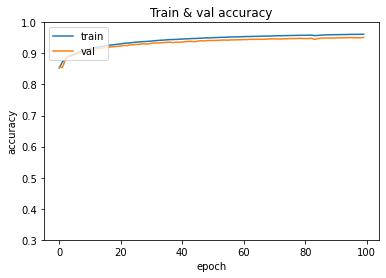

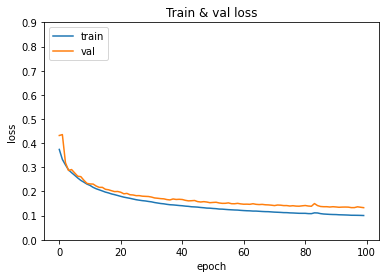

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.yticks(list(np.arange(0.3, 1.1, 0.10)))
plt.title('Train & val accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yticks(list(np.arange(0.0, 1.0, 0.10)))
plt.title('Train & val loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

(256, 256)


Text(0.5, 1.0, 'Image prédit')

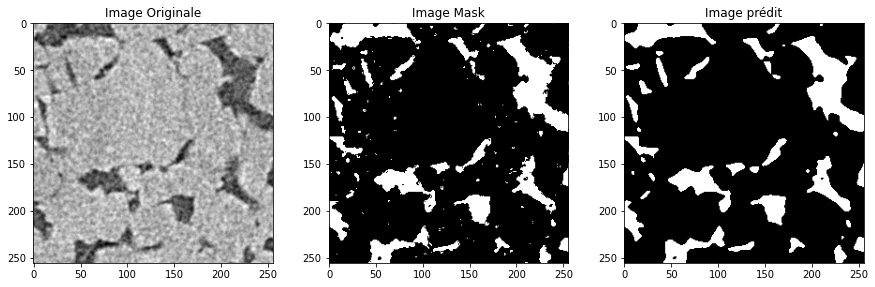

In [ ]:
id = 17
print(x_test[id].shape)
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(3,3,1)
ax1.imshow((x_test[id]).reshape(256,256),cmap='gray')
plt.title('Image Originale')
ax2 = fig.add_subplot(3,3,2)
ax2.imshow((y_test[id]).reshape(256,256),cmap='gray')
plt.title('Image Mask')
ax3 = fig.add_subplot(3,3,3)
ax3.imshow((Y_pred[id]).reshape(256,256),cmap='gray')
plt.title('Image prédit')


In [ ]:
reconstructed_model = tensorflow.keras.models.load_model("/content/drive/My Drive/PIBD/saved_model_TL980.h5")

Visualiser la différence entre image prédite et image masque avec matrice de confusion à code couleur

In [ ]:
def get_confusion_matrix_intersection_mats(groundtruth, predicted):

    confusion_matrix_arrs = {}

    groundtruth_inverse = np.logical_not(groundtruth)
    predicted_inverse = np.logical_not(predicted)

    confusion_matrix_arrs['tp'] = np.logical_and(groundtruth, predicted)
    confusion_matrix_arrs['tn'] = np.logical_and(groundtruth_inverse, predicted_inverse)
    confusion_matrix_arrs['fp'] = np.logical_and(groundtruth_inverse, predicted)
    confusion_matrix_arrs['fn'] = np.logical_and(groundtruth, predicted_inverse)

    return confusion_matrix_arrs

white - TP
Magenta - FP
Yellow - FN
Black - TN


Text(0.5, 1.0, 'confusion matrix overlay mask')

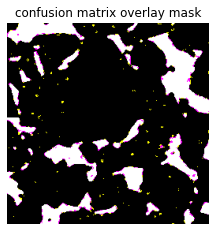

In [ ]:
def get_confusion_matrix_overlaid_mask(image, groundtruth, predicted, colors):

    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    masks = get_confusion_matrix_intersection_mats(groundtruth, predicted)
    color_mask = np.zeros_like(image)
    for label, mask in masks.items():
        color = colors[label]
        mask_rgb = np.zeros_like(image)
        mask_rgb[mask != 0] = color
        color_mask += mask_rgb
    return cv2.addWeighted(image, alpha, color_mask, 1 - alpha, 0)
#addweighted: Ici j'ai pris deux images pour les mélanger.

alpha = 0
confusion_matrix_colors = {
   'tp': (255, 255, 255),  #white
   'fp': (255, 0, 255),  #magenta
   'fn': (255, 255, 0),  #yellow
   'tn': (0,0,0)     #black
   }
validation_mask = get_confusion_matrix_overlaid_mask(x_test[17], y_test[17], y_pred[17], confusion_matrix_colors)
print('white - TP')
print('Magenta - FP')
print('Yellow - FN')
print('Black - TN')

plt.figure(figsize=(3.7,3.7))
plt.imshow(validation_mask)
plt.axis('off')
plt.title('confusion matrix overlay mask')